## Model

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import matplotlib.pyplot as plt
import numpy as np
from lab.tensorflow import B
from stheno import EQ, GP
from varz.tensorflow import Vars, minimise_l_bfgs_b
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

class NSGPRegression:
    def __init__(self, X, y, num_inducing_points):
        self.num_inducing_points = num_inducing_points
        self.X = X
        self.y = y
        assert len(X.shape) == 2
        assert len(y.shape) == 2
        self.input_dim = X.shape[1]
    
        # Defining X_bar (Locations where latent lengthscales are to be learnt)
        self.X_bar = KMeans(n_clusters=num_inducing_points).fit(self.X).cluster_centers_
        
    def LocalGP(self, vs, X): # Getting lengthscales for entire train_X (self.X)
        '''
        "vs" is very specially used here. It's kind of bucket of training variables.
        We may use a subset of items from this bucket in any function but we can pass "vs" to all functions.
        More details on "varz" package README by wesselb.
        '''
        l_list = []
        for dim in range(self.input_dim):
            f = GP(vs.positive(init = 1., name='local_std')*\
                EQ().stretch(vs.positive(1., name='local_gp_ls'+str(dim))))
            f_post = f | (f(self.X_bar[:, dim]), 
                          B.log(vs.positive(B.ones(self.num_inducing_points,), 
                                    shape=(self.num_inducing_points,), name='local_ls'+str(dim))))
            l = B.exp(f_post(X[:, dim]).mean.mat)
            l_list.append(l)
        
        return l_list
    
    def GlobalGP(self, vs): # Construct global GP and return nlml
        l_list = self.LocalGP(vs, self.X)
        global_ls = tf.concat(l_list, axis=1)
        
        f = GP(EQ().stretch(global_ls))
        
        return -f(self.X, vs.positive(1., name='global_noise')).logpdf(self.y)
    
    def optimize(self, iters=1000, jit=False): # Optimize hyperparams
        self.vs = Vars(tf.float64)
        minimise_l_bfgs_b(self.GlobalGP, self.vs, trace=True, jit=jit, iters=iters)
        self.vs.print()
        
    def predict(self, X_new): # Predict at new locations
        l_list = self.LocalGP(self.vs, self.X)
        global_ls = tf.concat(l_list, axis=1)
        
        f = GP(EQ().stretch(global_ls))
        
        f_post = f | (f(self.X), self.y)
        pred_y = f_post(X_new, self.vs['global_noise'])
        
        return pred_y.mean.mat, pred_y.var.mat

In [3]:
# from model import NSGPRegression

## Data (Step-function)

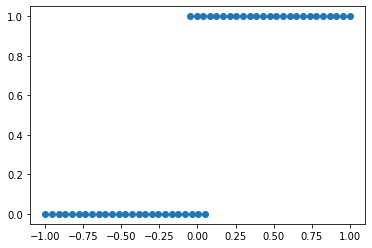

In [3]:
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

num_low=25
num_high=25
gap = -.1
noise=0.0001
X = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))

plt.scatter(X, y);

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

### Visualize the fit

Minimisation of "GlobalGP":
    Iteration 1/1000:
        Time elapsed: 0.0 s
        Time left:  37.2 s
        Objective value: 30.47
    Iteration 27/1000:
        Time elapsed: 0.6 s
        Time left:  15.8 s
        Objective value: -2.998
    Done!
Termination message:
    CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
local_std:  1.0
local_gp_ls0: 0.4848
local_ls0:  [0.96379364 2.01217814 0.40338733 0.84544377 2.26359887]
global_noise: 0.04039


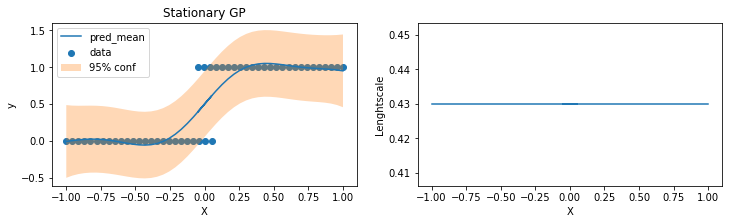

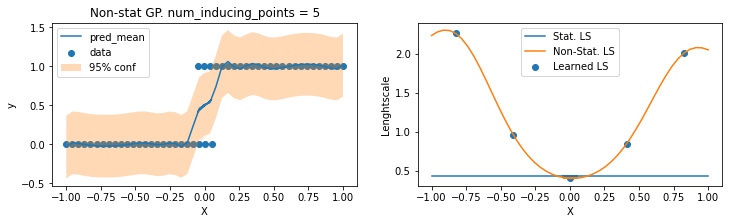

In [4]:
# Stationary GP

import GPy
m = GPy.models.GPRegression(X, y, GPy.kern.RBF(X.shape[1]))
m.optimize_restarts(5, verbose=False)

pred_y, var_y = m.predict(X)
pred_y = pred_y.ravel()
std2_y = np.sqrt(var_y.ravel())*2

fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].set_title('Stationary GP')
ax[0].scatter(X, y, label='data')
ax[0].plot(X, pred_y, label='pred_mean')
ax[0].fill_between(X[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
ax[0].legend()

ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y))
ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');


# Non-stationary GP (n=10)
n = 5
model = NSGPRegression(X, y, n)
model.optimize()

pred_y, var_y = model.predict(X)
pred_y = pred_y.numpy()
std2_y = np.sqrt(var_y.numpy().diagonal())*2

fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].set_title('Non-stat GP. num_inducing_points = '+str(n))
ax[0].scatter(X, y, label='data')
ax[0].plot(X, pred_y, label='pred_mean')
ax[0].fill_between(X[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
ax[0].legend()

ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y), label='Stat. LS')
ax[1].plot(X.ravel(), np.array(model.LocalGP(model.vs, X)).ravel(), label='Non-Stat. LS')
ax[1].scatter(model.X_bar, model.vs['local_ls0'], label='Learned LS');
ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');
ax[1].legend();

In [4]:
model.predict(B.random.rand(10,2))

NameError: name 'model' is not defined

(100, 1) (100, 1)


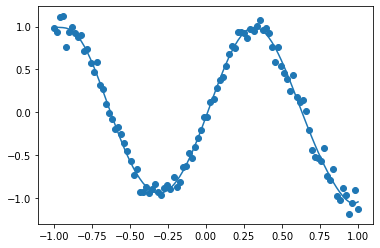

In [15]:
x = np.linspace(-1,1,100).reshape(-1,1)
y = np.sin(5*x) + np.random.normal(0,0.1,100).reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x,y)

f = GP(EQ())
f_ = f | (f(x), y)

plt.plot(x, f_(x).mean.mat);